In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-entity-sentiment-analysis' dataset.
Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [2]:
# ===============================
#  Install & Import Libraries
# ===============================
!pip install tensorflow scikit-learn nltk kaggle --quiet

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Read data
names=["tweet_id","entity","sentiment","content"]
train_df = pd.read_csv(path + "/twitter_training.csv", names=names)
test_df  = pd.read_csv(path + "/twitter_validation.csv", names=names)

print(train_df.head())

   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                             content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [4]:
# ===============================
#  Clean Text
# ===============================
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', str(text))
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text

train_df['clean_text'] = train_df['content'].apply(clean_text)
test_df['clean_text']  = test_df['content'].apply(clean_text)

In [5]:
# ===============================
#  Tokenization & Padding
# ===============================
max_words = 10000   # vocabulary size
max_len   = 100     # max length of tweet

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Filter out 'Irrelevant' sentiment before creating X_train
train_df_filtered = train_df[train_df['sentiment'] != 'Irrelevant'].copy()
test_df_filtered  = test_df[test_df['sentiment'] != 'Irrelevant'].copy()


X_train = pad_sequences(tokenizer.texts_to_sequences(train_df_filtered['clean_text']),
                        maxlen=max_len, padding='post')
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df_filtered['clean_text']),
                        maxlen=max_len, padding='post')

In [6]:
# ===============================
#  Encode Labels
# ===============================
encoder = LabelEncoder()

# Filter out 'Irrelevant' sentiment - this is now done before tokenization, but keeping here for y_train
train_df_filtered = train_df[train_df['sentiment'] != 'Irrelevant'].copy()
test_df_filtered  = test_df[test_df['sentiment'] != 'Irrelevant'].copy()


y_train = encoder.fit_transform(train_df_filtered['sentiment'])
y_test  = encoder.transform(test_df_filtered['sentiment'])

print("Classes:", encoder.classes_)

Classes: ['Negative' 'Neutral' 'Positive']


In [7]:
# ===============================
#  Build LSTM Model
# ===============================
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.classes_), activation='softmax'))  # Use the number of classes from the encoder

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ===============================
#  Train Model
# ===============================
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=64)

Epoch 1/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 216s 274ms/step - accuracy: 0.3488 - loss: 1.0976 - val_accuracy: 0.4021 - val_loss: 1.0939
Epoch 2/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 198s 257ms/step - accuracy: 0.3576 - loss: 1.0958 - val_accuracy: 0.4021 - val_loss: 1.0923
Epoch 3/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 206s 262ms/step - accuracy: 0.3527 - loss: 1.0966 - val_accuracy: 0.2991 - val_loss: 1.0975
Epoch 4/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 197s 255ms/step - accuracy: 0.3569 - loss: 1.0962 - val_accuracy: 0.4021 - val_loss: 1.0945
Epoch 5/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 197s 255ms/step - accuracy: 0.3582 - loss: 1.0956 - val_accuracy: 0.4021 - val_loss: 1.0941


In [9]:
# ===============================
#  Evaluate Model
# ===============================
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3298 - loss: 1.1008
Test Accuracy: 0.32125604152679443


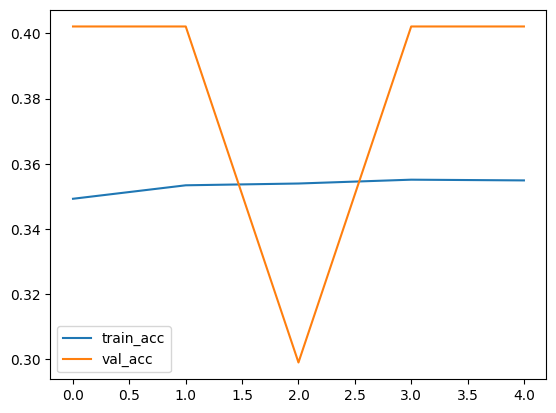

In [10]:
# ===============================
#  Plot Training Results
# ===============================
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [11]:
# ===============================
#  Predict Function
# ===============================
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([clean_text(text)])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)
    label = encoder.inverse_transform([pred.argmax()])[0]
    return label

print(predict_sentiment("I love this product!"))
print(predict_sentiment("This is the worst service ever."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Negative


In [12]:
# ===============================
#  Save tokenizer and encoder
# ===============================
import joblib
joblib.dump(tokenizer, "tokenizer.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

In [13]:
# ===============================
#  download tokenizer and encoder
# ===============================
from google.colab import files

files.download("tokenizer.pkl")
files.download("encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# ===============================
#  Save Model
# ===============================
model.save("sentiment_model.h5")

from google.colab import files
files.download("sentiment_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>